# Importing necessary libraries

In [1]:
from collections import Counter
from zipfile import ZipFile
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt 

from xgboost import XGBClassifier
import numpy as np

# Preparing data

In [2]:
zip_file = ZipFile('../../data/out/clean.zip')
df_clean = pd.read_csv(zip_file.open('clean.csv'))

df_clean.head()

,is_app_approved,bad,annual_income,all0000,all0060,all0061,all0101,all0200,all0201,all0206,...,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
0,1,0.0,15171,10.0,8.000000,8.000000,0.0,9.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,20000,3.0,4.165954,5.237061,0.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,7000,6.0,4.165954,5.237061,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.0,18000,3.0,1.000000,1.000000,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,30000,6.0,4.165954,5.237061,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Oversampling

In [3]:
# oversample = SMOTE()
X = df_clean.drop(columns='bad')
y = df_clean.bad.astype(int)
# counter = Counter(y)
# print(counter)

# X,y = oversample.fit_resample(X,y)
# counter = Counter(y)
# print(counter)

## Standard Scale the data

In [4]:
scaler = StandardScaler()
scaler.fit(X)
scaled_data = pd.DataFrame(scaler.transform(X), columns = X.columns)
X = scaled_data

Splitting the dataset into train/test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Oversampling on training

In [6]:
oversample = SMOTE()
counter = Counter(y_train)
print(counter)

X_train,y_train = oversample.fit_resample(X_train,y_train)
counter = Counter(y_train)
print(counter)

Counter({0: 27212, 1: 2570})
Counter({0: 27212, 1: 27212})


# Models

## Logistic Regression

In [16]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8017 3625]
 [ 485  638]]
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     11642
           1       0.15      0.57      0.24      1123

    accuracy                           0.68     12765
   macro avg       0.55      0.63      0.52     12765
weighted avg       0.87      0.68      0.75     12765



## XGBoost

In [17]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[17:59:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[11549    93]
 [ 1046    77]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     11642
           1       0.45      0.07      0.12      1123

    accuracy                           0.91     12765
   macro avg       0.68      0.53      0.54     12765
weighted avg       0.88      0.91      0.88     12765



## Random Forest

In [18]:
rdnfst = RandomForestClassifier()
rdnfst.fit(X_train, y_train)
y_pred = rdnfst.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11610    32]
 [ 1075    48]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.95     11642
           1       0.60      0.04      0.08      1123

    accuracy                           0.91     12765
   macro avg       0.76      0.52      0.52     12765
weighted avg       0.89      0.91      0.88     12765



# Week 8 Discussion 

In [7]:
para_grid = {
'n_estimators': [100,200],
 'max_depth': [5,10,15],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 }

rdnfst = RandomForestClassifier(n_jobs=-1)
clf = GridSearchCV(rdnfst, para_grid, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [8]:
clf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [15]:
model = RandomForestClassifier(max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1)
model.fit(X, y)

RandomForestClassifier(max_depth=15, n_estimators=200, n_jobs=-1)

In [16]:
import pickle as pkl

pkl.dump(model,open("model.pkl", "wb"))

In [9]:
display(pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
37,100.509140,0.335075,0.379777,0.107423,15,1,2,200,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.944153,0.999169,0.999440,0.999340,0.999047,0.988230,0.022039,1
39,101.670366,1.387419,0.503064,0.132713,15,1,5,200,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.942520,0.999193,0.999398,0.999306,0.998994,0.987882,0.022682,2
36,51.690630,6.478703,0.179805,0.081541,15,1,2,100,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.941708,0.999161,0.999435,0.999447,0.999063,0.987763,0.023028,3
43,107.589379,1.193195,0.512703,0.081000,15,2,2,200,"{'max_depth': 15, 'min_samples_leaf': 2, 'min_...",0.939504,0.999250,0.999446,0.999410,0.999085,0.987339,0.023918,4
45,110.629795,0.748890,0.522677,0.131939,15,2,5,200,"{'max_depth': 15, 'min_samples_leaf': 2, 'min_...",0.939093,0.999261,0.999362,0.999414,0.998970,0.987220,0.024064,5


In [68]:
clf=model

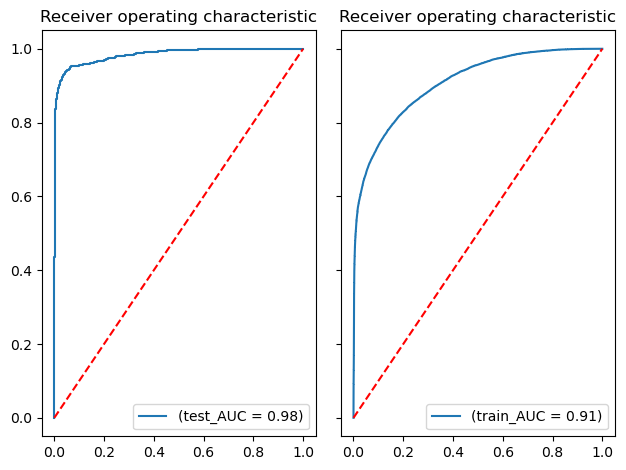

<Figure size 640x480 with 0 Axes>

In [69]:
fig, axes = plt.subplots(1, 2, sharey=True)

logit_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

axes[0].plot(fpr, tpr, label='(test_AUC = %0.2f)' % logit_roc_auc)
axes[0].plot([0, 1], [0, 1],'r--')

axes[0].title.set_text('Receiver operating characteristic')
axes[0].legend(loc="lower right")


logit_roc_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
plt.figure()
axes[1].plot(fpr, tpr, label='(train_AUC = %0.2f)' % logit_roc_auc)
axes[1].plot([0, 1], [0, 1],'r--')

axes[1].title.set_text('Receiver operating characteristic')
axes[1].legend(loc="lower right")

fig.tight_layout()

plt.show()

In [ ]:
# def final_model(raw_data):
#     clean_data = data_cleaner(raw_data) # Fully cleans data
#     final_proba = BEST_MODEL.predict_proba(clean_data)
#     final_preds = BEST_MODEL.predict(clean_data)

In [22]:
X['is_app_approved'].value_counts()



0.0    42547
Name: is_app_approved, dtype: int64

In [23]:
X

,is_app_approved,annual_income,all0000,all0060,all0061,all0101,all0200,all0201,all0206,all0217,...,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
0,0.0,-0.028761,-0.210205,0.260975,-0.025504,-0.104305,-0.228152,-0.029356,1.408012,-0.093226,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,-0.152258,-0.132585,-0.086226,-0.036626
1,0.0,-0.027369,-0.794682,-0.483064,-0.589581,-0.104305,-0.758695,-0.029356,-0.216488,-0.844642,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,-0.152258,-0.132585,-0.086226,-0.036626
2,0.0,-0.031116,-0.544192,-0.483064,-0.589581,-0.104305,-0.670271,-0.029356,-0.216488,-0.594170,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,-0.152258,-0.132585,-0.086226,-0.036626
3,0.0,-0.027946,-0.794682,-1.097452,-1.454611,-0.104305,-0.847119,-0.029356,-0.216488,-0.844642,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,-0.152258,-0.132585,-0.086226,-0.036626
4,0.0,-0.024487,-0.544192,-0.483064,-0.589581,-0.104305,-0.847119,-0.029356,-0.216488,-0.844642,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,-0.152258,-0.132585,-0.086226,-0.036626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42542,0.0,0.002894,-0.043211,0.514275,0.615503,-0.104305,-0.051304,-0.029356,-0.216488,-0.093226,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,-0.152258,-0.132585,-0.086226,-0.036626
42543,0.0,-0.004023,3.964634,2.783768,0.615503,-0.104305,2.778259,-0.029356,-0.216488,2.787204,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,-0.152258,-0.132585,-0.086226,-0.036626
42544,0.0,0.008659,3.380156,0.514275,0.615503,-0.104305,3.574074,-0.029356,-0.216488,4.415273,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,-0.152258,-0.132585,-0.086226,-0.036626
42545,0.0,-0.012382,-0.460695,0.514275,0.615503,-0.104305,-0.404999,-0.029356,-0.216488,-0.468934,...,-0.046297,-0.137546,-0.263125,-0.080804,-0.154106,-0.0545,6.567792,-0.132585,-0.086226,-0.036626


In [27]:
TEST = pd.read_csv('../../test/testdata.csv')



In [28]:
TEST

,is_app_approved,bad,annual_income,all0000,all0060,all0061,all0101,all0200,all0201,all0206,...,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
40547,1,0.0,83000,7.0,1.000000,1.000000,0.0,7.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
40548,1,0.0,77000,12.0,2.000000,11.139763,0.0,12.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
40549,1,0.0,76000,38.0,30.000000,30.000000,0.0,34.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
40550,1,0.0,85000,15.0,9.305257,11.139763,0.0,15.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
40551,1,0.0,100000,4.0,9.305257,11.139763,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42542,1,0.0,125000,12.0,9.305257,11.139763,0.0,11.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42543,1,0.0,101000,60.0,21.000000,11.139763,0.0,43.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42544,1,0.0,145000,53.0,9.305257,11.139763,0.0,52.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
42545,1,0.0,72000,7.0,9.305257,11.139763,0.0,7.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [48]:
predictions = pd.read_csv('../../predictions.csv')

In [49]:
predictions

,0
0,0
1,0
2,0
3,0
4,0
...,...
1995,0
1996,0
1997,0
1998,0


In [63]:
actual = TEST['bad'].to_numpy()

In [64]:
pred = predictions.iloc[:, 0].to_numpy()


In [66]:
(actual - pred).mean()

0.068